In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mplcursors      # Allows interactive matplotlib graphs

# Used to smooth jagged histograms
from scipy.interpolate import BSpline
from scipy.ndimage.filters import gaussian_filter

# Local library to read and prep data from dmv akts events in splunk
import dmv_test_input as dti 

def read_log(case=1, field="duration"):
    # Read and prepare the dmv_akts. Case=1 ... sample ... =2 ... akts database
#     df = dti.read_dmv_log(case=case)

    # Read and cleanse data from akts log and risk database
    df, risk = dti.dmv_risk_input(case=2, save=False)    
    
    df["elapsed"] = abs(df['TestEndDateTime'] - df['TestStartDateTime']).dt.total_seconds()/60.
    df["passed"]  = (df.Result=="P")
    
    # Drop negative duration since they must be in error
    # Drop long durations because the chance of error is high
    
    df = df[ (df.duration>0) & (df.duration<120) & (df.elapsed<120)].reset_index()
    
    return df, risk
        
df, risk = read_log(case=2)
changept = 14.5
print(f'{changept=}')
col = ["ExamineeId", "TestStartDateTime", "TotalScore", "duration", "elapsed", "passed"]


Original length of sample data is 179142
2862 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 1183 tests


Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'


changept=14.5


In [29]:
def find_intersect(x, y, x0):
    # Intepolate y0=f(x0) when f(x) is a discrete set of points {(x[i], y[i])}
    # Caution x must be between endpoints; x is monotonically increasing
    for i in list(range(len(df.duration)))[1:]:
        if x[i] > x0:
            m = (x[i]-x[i-1]) /( y[i]-y[i-1])
            return y[i] + m*(x0 - x[i-1])

def lbl_point(ax, x0, y0, tx, ty):
    # annotate a point with an arrow with test offset by (tx,ty)*1/8 inch (9 points)
    inc = 9
    point = (x0, y0)          # point in axis
    label = (tx*inc, ty*inc)  # offset position of text from point
    ax.annotate(f'{y0:.0f}', 
                xy=point, xycoords='data',
                xytext=label, textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05))


In [3]:
len(df)

174287

In [4]:
# Add the ip risk and score to log data


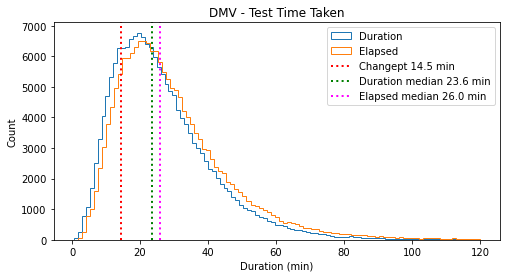

In [5]:
def draw_duration(x, changept, fw=8, fh=4):
    # Graph histogram to compare use of duration and elapsed time
    # duration ... time taken to finish test as reported in akts (min)
    # elapsed .... elapsed clock time from start to finish (min)
    fig, ax = plt.subplots(figsize=(fw, fh))

    h1 = ax.hist(x.duration, bins=100, histtype="step", label="Duration")
    h2 = ax.hist(x.elapsed, bins=100, histtype="step", label="Elapsed")

    duration_median = x.duration.median()
    elapsed_median = x.elapsed.median()
    
    l1 = ax.axvline(x=changept, color="red", linewidth=2, ls=":", label=f"Changept {changept} min")
    l2 = ax.axvline(x=duration_median, color="green", linewidth=2, ls=":", label=f"Duration median {duration_median:.1f} min")
    l3 = ax.axvline(x=elapsed_median, color="magenta", linewidth=2, ls=":", label=f"Elapsed median {elapsed_median:.1f} min")

    ax.set_title(f'DMV - Test Time Taken')
    ax.set_xlabel(f'Duration (min)')
    ax.set_ylabel(f'Count')
    ax.grid(False)
    ax.legend()
    plt.show
    return h1, ax

h1 = draw_duration(df, changept)

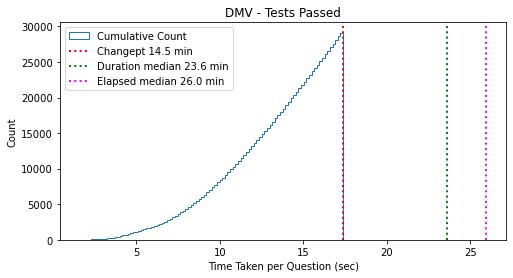

In [6]:
import mplcursors      # Allows interactive matplotlib graphs
def draw_duration_cum(df, changept, fw=8, fh=4):
    # Graph cumulative histogram to people passing in less than changept
    fig, ax = plt.subplots(figsize=(fw, fh))
    h1 = ax.hist(df[(df.duration<changept) & (df.passed==True)].duration*60/50, bins=100, histtype="step", label="Cumulative Count", cumulative=True)
    mplcursors.cursor(hover=True)

    duration_median = df.duration.median()
    elapsed_median = df.elapsed.median()
    
    l1 = ax.axvline(x=changept*60/50, color="red", linewidth=2, ls=":", label=f"Changept {changept} min")
    l2 = ax.axvline(x=duration_median, color="green", linewidth=2, ls=":", label=f"Duration median {duration_median:.1f} min")
    l3 = ax.axvline(x=elapsed_median, color="magenta", linewidth=2, ls=":", label=f"Elapsed median {elapsed_median:.1f} min")

    ax.set_title(f'DMV - Tests Passed')
    ax.set_xlabel(f'Time Taken per Question (sec)')
    ax.set_ylabel(f'Count')
    ax.grid(False)
    ax.legend()
    plt.show
    return h1, ax

hc1 = draw_duration_cum(df, changept)

In [7]:
len(df)


174287

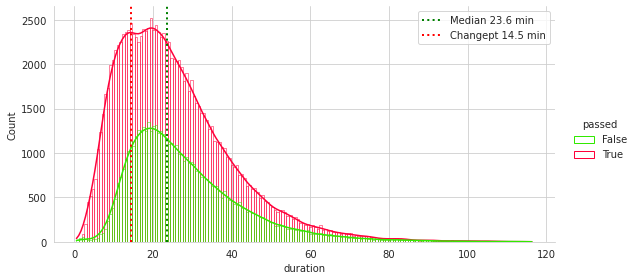

In [8]:
def duration_kde(df, field, vert, fw=8, fh=4):

    sns.set_style("whitegrid")
    g1 = sns.displot(data=df, x=field, hue="passed",
                     kde=True, 
                     palette='prism',
                     height=fh,
                     fill=False,
                     aspect=2)

    median = df[field].median()
    plt.axvline(x=median, color="green", linewidth=2, ls=":", label=f"Median {median:.1f} min")
    plt.axvline(x=vert, color="red", linewidth=2, ls=":", label=f"Changept {vert:.1f} min")

    plt.legend()
    return g1

g1 = duration_kde(df, "duration", 14.5)

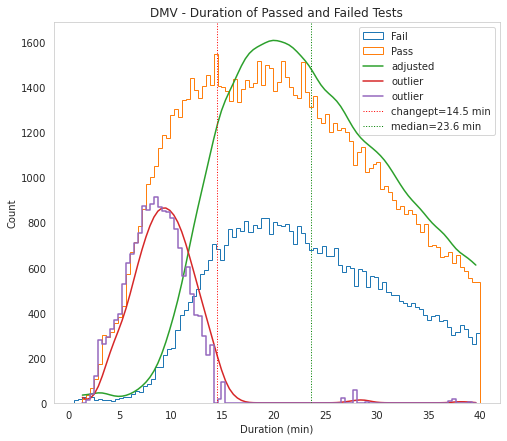

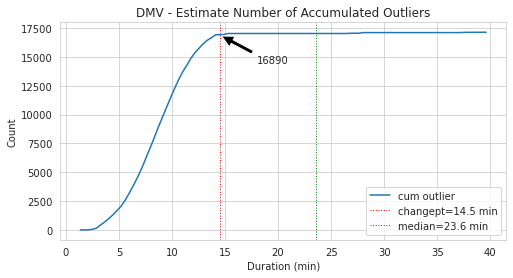

In [9]:
def draw_passfail_duration(x, changept, rate, fw=8, fh=4):
    # Graph compares tests that pass, fail to an estimate of outlier count
    # outliers are tests with scores higher than the long term average
    
    def smooth(x, y, order=3, num=100):
        # Smooth with a gaussian filter and then spline interpolation
        yfiltered = gaussian_filter(y, sigma=2)
        smoother = BSpline(x, yfiltered, order)
        u = np.linspace(x.min(), x.max(), num)

        return u, smoother(u)

    def draw_outlier_cum(p, changept, rate, median, fw=8, fh=4):
        # Draw the cumulative outliers
        p['cum_outlier'] = p.outlier.cumsum()

        fig, ax = plt.subplots(figsize=(fw, fh))
        ax.plot(p.duration, p.cum_outlier, label='cum outlier')
        ax.axvline(x=changept, color="red", linewidth=1, ls=":", label=f"{changept=} min")
        ax.axvline(x=median, color="green", linewidth=1, ls=":", label=f"{median=:.1f} min")
        intercept = 16890
        xy = (14.5, intercept)
        xytext = (18, intercept-2400)
        ax.annotate(str(intercept), xy=xy, xytext=xytext, arrowprops=dict(facecolor='black', shrink=0.05))
        ax.set_title(f'DMV - Estimate Number of Accumulated Outliers')
        ax.set_xlabel(f'Duration (min)')
        ax.set_ylabel(f'Count')
        ax.legend(loc='lower right')
        ax.grid(True)
        plt.show()
    
    # Find median of all the data
    median = x.duration.median()

    fig, ax = plt.subplots(figsize=(fw, fh))
    
    # Exclude tests that take a long time or have questionable time
    # Also minimizes the effect of long tail for short duration tests
    df = x[(x.duration > 0) & (x.duration <= 40) & (x.elapsed > 0) & (x.elapsed < 60)]
    
    # Draw histograms of the tests that pass and fail
    h1 = ax.hist(df[(df.Result!='P')].duration, bins=100, histtype="step", label="Fail")
    h2 = ax.hist(df[(df.Result=='P')].duration, bins=100, histtype="step", label="Pass")
    # Draw x=0 axis
    ax.axhline(y=0, color="gray", linewidth=1)

    # Use the counts calculated by plt.hist to find:
    # adjusted ... # tests expected to pass based on passing rate for duration > changept
    # outlier  ... # tests that occurred greater than the expected rate of passing
    # 
    # Exclude last duration, the outer edge of last bin. 
    # In following we use the calculated results made by plt.hist
    #    h1[0] ... counts of the people who failed in a duration bin
    #    h1[1] ... leading edge of the bin
    #    h2[0] ... counts of the people who passed in a duration bin
    #    h2[1] ... leading edge on the bin
    
    p = pd.DataFrame(h2[1][:-1], columns=['duration'])
    p['pass'] = h2[0]
    p['fail'] = h1[0]
    p['adjusted'] = p['fail']*(rate/(1. - rate))              # passing rate is .67
    p['outlier'] = p['pass'] - p['adjusted']
    # The number of outliers cannot be less than 0
    p['outlier'] = p['outlier'].apply(lambda x: x if x>0 else 0)

    # Smooth the jaggy histograms into a smooth curves
    u, v = smooth(p.duration, p.adjusted, order=2, num=100)
    h3 = ax.plot(u, v, label='adjusted')
#     h3 = ax.step(p.duration, p.adjusted, label='expected')

    u, v = smooth(p.duration, p.outlier, order=2, num=100)
    h4 = ax.plot(u, v, label='outlier')
    h5 = ax.step(p.duration, p['outlier'], label='outlier')

    # Display the changept and median
    ax.axvline(x=changept, color="red", linewidth=1, ls=":", label=f"{changept=} min")
    ax.axvline(x=median, color="green", linewidth=1, ls=":", label=f"{median=:.1f} min")

    ax.set_title(f'DMV - Duration of Passed and Failed Tests')
    ax.set_xlabel(f'Duration (min)')
    ax.set_ylabel(f'Count')
    ax.grid(False)
    ax.legend(loc='upper right')
    plt.show
    
    draw_outlier_cum(p, changept, rate, median)
    return h1, h2, h3, h4, h5, p

h1, h2, h3, h4, h5, p = draw_passfail_duration(df, 14.5, .67, fw=8, fh=7)

In [30]:
def graph_comparison(x, fw=8, fh=7):
    # Graph compares duration distributions for passing tests to before the cutoff
    # These tests were geofenced starting 10/27
    
    def graph_histo(df):   
        # Graph histo of all tests and tests before cutoff
 
        fig, ax = plt.subplots(figsize=(fw, fh))
 
        # All the passed tests
        all_time      = ax.hist(df.duration, 
                        bins=25, histtype="step", 
                        label="All Passed Tests")
        # Passed before the cutoff date. Shows how it was before geofencing.
        before_cutoff = ax.hist(
                        df[(df.TestStartDateTime <= C.time_cutoff)].duration,
                        bins=25, histtype="step", 
                        label=f'Before Geofencing {C.time_cutoff}')
        # Draw x=0 axis
        ax.axhline(y=0, color="gray", linewidth=1)
        # Display the changept and median
        ax.axvline(x=C.changept, color="red", linewidth=1, ls=":", label=f"{C.changept=} min")
        ax.axvline(x=median, color="green", linewidth=1, ls=":", label=f"{median=:.1f} min")

        ax.set_title(C.title_histo)
        ax.set_xlabel(f'Duration (min)')
        ax.set_ylabel(f'Count of Passed Tests')
        ax.grid(False)
        ax.legend(loc='upper right')
        plt.show
        # Return plt objects so calculated distributions can be used
        return all_time, before_cutoff

    def histo_data(before_cutoff, all_time):
        # Use the counts calculated by plt.hist to find:
        # before_cutoff ... # passed tests before time_cutoff
        # all_time  ....... # passed tests that during all time
        # 
        # Exclude last duration, the outer edge of last bin. 
        # In following we use the calculated results made by plt.hist
        #    *[0] ... counts
        #    *[1] ... leading edges of the bins

        dr = pd.DataFrame(before_cutoff[1][:-1], columns=['duration'])
        dr['before_cutoff'] = before_cutoff[0]
        dr['all_time'] = all_time[0]
        return dr
    
    def graph_cum(df):
        # Graph the cumulative distribution
        
        df['cum_all_time'] = df['all_time'].cumsum()
        df['cum_before_cutoff'] = df['before_cutoff'].cumsum()

        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(df.duration, df.cum_before_cutoff, label=f'cum before {C.time_cutoff}')
        ax.plot(df.duration, df.cum_all_time, label='cum all time')
        ax.axvline(x=C.changept, color="red", linewidth=1, ls=":", label=f"{C.changept=} min")
        ax.axvline(x=median, color="green", linewidth=1, ls=":", label=f"{median=:.1f} min")
        
        # Label intersection of median with cdf with arrow and value
        intersect_all = find_intersect(df.duration, df.cum_all_time, median)
        intersect_before = find_intersect(df.duration, df.cum_before_cutoff, median)
        lbl_point(ax, median, intersect_all, -8, 1)
        lbl_point(ax, median, intersect_before, -8, 1)
        
        ax.set_title(C.title_cum)
        ax.set_xlabel(f'Duration (min)')
        ax.set_ylabel(f'Count')
        ax.legend(loc='center right')
        ax.grid(True)
        plt.show()
#     import pdb; pdb.set_trace()
 
    all_time, before_cutoff = graph_histo(x)
    dr = histo_data(all_time, before_cutoff)
    graph_cum(dr)
    return dr

def filter_prep(df):
    # Exclude tests that take a long time or have questionable time
    # Also minimizes the effect of long tail for short duration tests
    result = df[(df.duration > 0) & (df.duration <= 40) 
           & (df.elapsed > 0) & (df.elapsed < 60)].reset_index()
    # Replace country==Nan with unknown. They will be treated as non-native
    result.country.fillna('unknown', inplace=True)
    # Restrict to passed tests
    return result[result.Result=="P"]   

def filter_risky(df):
    # Filter raw data to include passed tests that used risky ip addresses
    result = filter_prep(df)
    
    # Restrict to tests from ip addresses that are risky
    result = result[result.score > C.risk_cutoff]
    return result

def filter_foreign(df):
    # Filter raw data to include passed tests that used ip from outside USA
    result = filter_prep(df)
    
    # Restrict to tests from ip addresses outside USA
    result['native'] = result.country.isin(['United States', 'Puerto Rico'])
    result = result[~result.native]    
    return result

class Parameters():
    def __init__(self):
        self.time_cutoff = '11/15/2021'
        self.risk_cutoff = 20
        self.changept = 14.5
        self.rate = 0.67
        self.title_histo = f'Passed v Duration - IP Risk > {self.risk_cutoff} - Compare to Before GeoFencing'
        self.title_cum   = f'Accumulated Passed Tests - IP Risk > {self.risk_cutoff}'

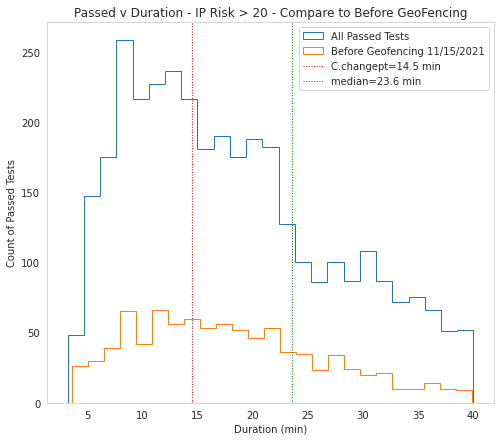

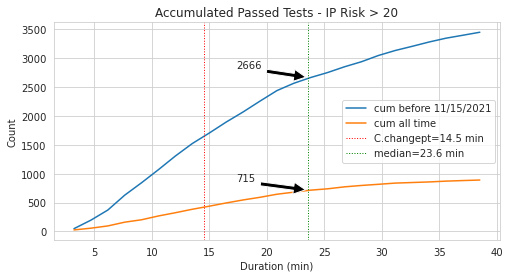

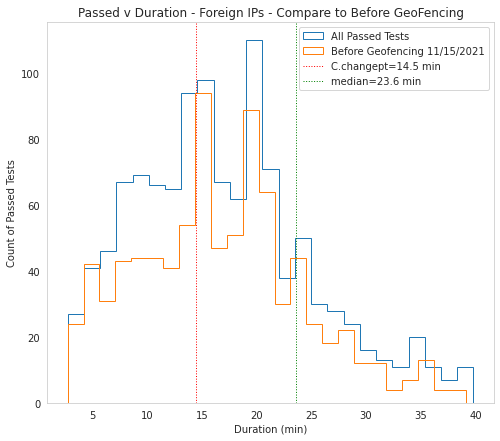

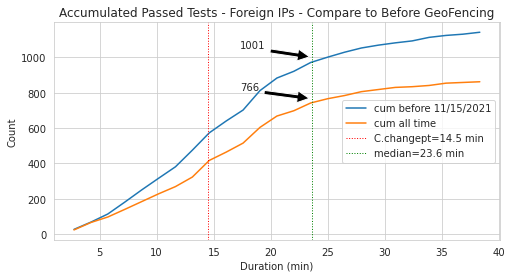

In [31]:
C = Parameters()

# Find median of all the data before it is filtered
median = df.duration.median()

# Compare passed tests for risky ip addresses
dr1 = graph_comparison( filter_risky(df) )

# Compare passed tests for foreign ip addresses
C.title_histo = f'Passed v Duration - Foreign IPs - Compare to Before GeoFencing'
C.title_cum   = f'Accumulated Passed Tests - Foreign IPs - Compare to Before GeoFencing'
dr2 = graph_comparison( filter_foreign(df) )

In [ ]:
dr1.to_clipboard()

In [ ]:
cs = ['United States', 'Puerto Rico']
time_cutoff = '11/2/2021'
def stat(df, cutoff):
    c1 = df[~(df.country.isin(cs)) & (df.TestStartDateTime<time_cutoff)].TotalScore.value_counts()
    c2 = df[~(df.country.isin(cs)) & (df.TestStartDateTime<time_cutoff)].TotalScore.value_counts()
    c3 = df[~(df.country.isin(cs))].TotalScore.value_counts()
    return c1, c2, c3
c1, c2, c3 = stat(df, time_cutoff)


In [ ]:
# c3 = pd.DataFrame(c1, columns=[f'Before {cutoff=}']) 
c3 = pd.DataFrame({f'Before {time_cutoff=}' : c1}) 
# c3 = pd.DataFrame(c1)
c3[f'After'] = c2
c3


In [ ]:
def risk_toframe(risk):
    # Convert risk dict to dataframe
    tlist =[]
    for cidr in risk.risk:
        tmp = risk.risk[cidr]
        tmp['cidr'] = cidr
        tlist.append(tmp)
    return pd.DataFrame(tlist)

r = risk_toframe(risk)

In [13]:
# How many passed who were 1) both ~US and risky 2) ~US and ~risky 3) ~~US and risky